# **Análisis de Desastres en Redes Sociales: Clasificación de Tweets para la Identificación de Eventos Catastróficos mediante Modelos de Aprendizaje Profundo**

Integrantes:
* NAYELLY COELLO
* GONZALEZ EMILY

Resumen
Este proyecto aborda la tarea crítica de identificar eventos catastróficos a través del análisis de tweets en redes sociales. Se emplea un enfoque de aprendizaje profundo, evaluando modelos como 1D CNN, RNN, BiGRU y BiLSTM. Aunque todos demuestran un rendimiento comparable en F1 score, la eficiencia computacional se convierte en un factor determinante. Se destaca que el modelo 1D CNN, caracterizado por su velocidad tanto en entrenamiento como en inferencia, supera a sus contrapartes más complejas.

IDEA ORIGINAL : https://www.kaggle.com/code/vicioussong/tweet-nlp-benchmark-1-cnn-rnn-with-glove

Datasets Completos: https://drive.google.com/drive/folders/1SWElPuxaeLKPtg2JZUa7p2fN4mB2cynR?usp=sharing

https://github.com/E2GM58/AI_Coello-Gonzalez



## Análisis de Datos y Visualización

* Carga de datos de entrenamiento y prueba desde archivos CSV.
* Análisis de la forma de los conjuntos de datos y visualización de los primeros registros.
* Exploración de valores perdidos en los conjuntos de datos.





In [4]:
# matplotlib and seaborn for plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
#Training data
train = pd.read_csv('train.csv')
print('Training data shape: ', train.shape)
train.head()

Training data shape:  (7613, 5)


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [6]:
# Testing data
test = pd.read_csv('test.csv')
print('Testing data shape: ', test.shape)
test.head()

Testing data shape:  (3263, 4)


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
#Missing values in training set
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

In [8]:
#Missing values in test set
test.isnull().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

In [9]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

<ipython-input-10-2f7fa574840e>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts(), palette='rocket')


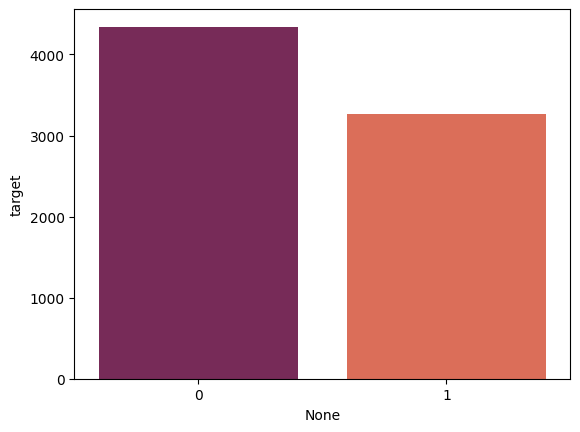

In [10]:
sns.barplot(x=train['target'].value_counts().index, y=train['target'].value_counts(), palette='rocket')
plt.show()

In [11]:
# A disaster tweet
disaster_tweets = train[train['target']==1]['text']
disaster_tweets.values[1]

'Forest fire near La Ronge Sask. Canada'

In [12]:
#not a disaster tweet
non_disaster_tweets = train[train['target']==0]['text']
non_disaster_tweets.values[1]

'I love fruits'

In [13]:
train['keyword'].value_counts()[:20]

fatalities     45
deluge         42
armageddon     42
sinking        41
damage         41
harm           41
body%20bags    41
outbreak       40
evacuate       40
fear           40
collided       40
siren          40
twister        40
windstorm      40
sinkhole       39
sunk           39
hellfire       39
weapon         39
weapons        39
famine         39
Name: keyword, dtype: int64

<Axes: xlabel='keyword', ylabel='None'>

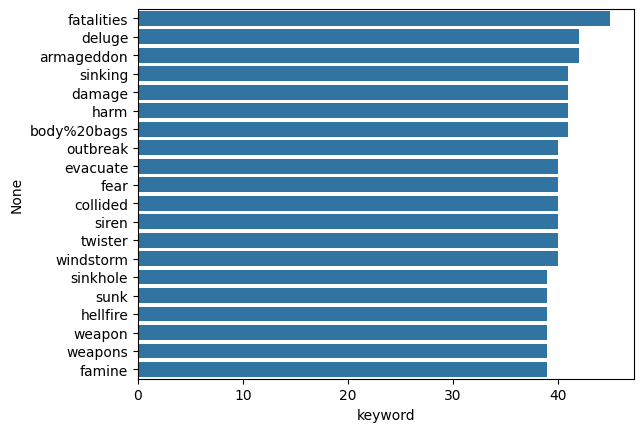

In [14]:
sns.barplot(y=train['keyword'].value_counts()[:20].index,x=train['keyword'].value_counts()[:20],
            orient='h')

In [15]:
train.loc[train['text'].str.contains('disaster', na=False, case=False)].target.value_counts()

1    102
0     40
Name: target, dtype: int64

**CIUDADES**

<Axes: xlabel='location', ylabel='None'>

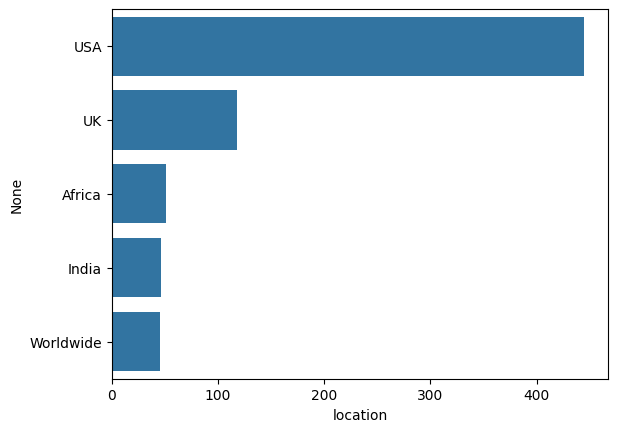

In [16]:
# Replacing the ambigious locations name with Standard names
train['location'].replace({'United States':'USA',
                           'New York':'USA',
                            "London":'UK',
                            "Los Angeles, CA":'USA',
                            "Washington, D.C.":'USA',
                            "California":'USA',
                             "Chicago, IL":'USA',
                             "Chicago":'USA',
                            "New York, NY":'USA',
                            "California, USA":'USA',
                            "FLorida":'USA',
                            "Nigeria":'Africa',
                            "Kenya":'Africa',
                            "Everywhere":'Worldwide',
                            "San Francisco":'USA',
                            "Florida":'USA',
                            "United Kingdom":'UK',
                            "Los Angeles":'USA',
                            "Toronto":'Canada',
                            "San Francisco, CA":'USA',
                            "NYC":'USA',
                            "Seattle":'USA',
                            "Earth":'Worldwide',
                            "Ireland":'UK',
                            "London, England":'UK',
                            "New York City":'USA',
                            "Texas":'USA',
                            "London, UK":'UK',
                            "Atlanta, GA":'USA',
                            "Mumbai":"India"},inplace=True)

sns.barplot(y=train['location'].value_counts()[:5].index,x=train['location'].value_counts()[:5],
            orient='h')

## Importación de Bibliotecas y Preprocesamiento de Datos

#### Libreria

In [17]:
# Basic
import os
import re
import time
import string

import warnings
warnings.filterwarnings('ignore')

# NLTK
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
stop = set(stopwords.words('english'))

# Machine Learning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, accuracy_score

# Deep Learning
import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import Constant
from keras.layers import Embedding, Conv1D, MaxPooling1D, SimpleRNN, GRU, LSTM, Bidirectional
from keras.layers import BatchNormalization, Dense, TimeDistributed, Dropout, Flatten, GlobalMaxPool1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


#### Datos

In [18]:
train = pd.read_csv('train.csv')
test  = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')

train_sent, test_sent, train_label = train.text.values, test.text.values, train.target.values

In [19]:
train.text.values

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected",
       ...,
       'M1.94 [01:04 UTC]?5km S of Volcano Hawaii. http://t.co/zDtoyd8EbJ',
       'Police investigating after an e-bike collided with a car in Little Portugal. E-bike rider suffered serious non-life threatening injuries.',
       'The Latest: More Homes Razed by Northern California Wildfire - ABC News http://t.co/YmY4rSkQ3d'],
      dtype=object)

# Procedimiento del tema:


*   Importación de bibliotecas necesarias.
* Tokenización de palabras usando NLTK.
* Preprocesamiento de datos para la aplicación de modelos de aprendizaje profundo.


In [20]:
from sklearn.metrics import classification_report
leak = pd.read_csv("socialmedia-disaster-tweets-DFE.csv", encoding='latin_1')
leak['target'] = (leak['choose_one']=='Relevant').astype(int)
leak['id'] = leak.index
leak = leak[['id', 'target','text']]
merged_df = pd.merge(test, leak, on='id')
gt_df = merged_df[['id', 'target']]
gt_df.to_csv('submit.csv', index=False)

## Preprocesamiento de Datos

In [21]:
# nltk: Tokenization
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train_sent)
vocab_length = len(word_tokenizer.word_index) + 1

In [22]:
def embed(corpus): return word_tokenizer.texts_to_sequences(corpus)

def metrics(y_true, y_pred):
    print("F1-score: ", round(f1_score(y_true, y_pred), 2))
    print("Precision: ", round(precision_score(y_true, y_pred), 2))
    print("Recall: ", round(recall_score(y_true, y_pred), 2))

def plot(history, arr):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))
    for idx in range(2):
        ax[idx].plot(history.history[arr[idx][0]])
        ax[idx].plot(history.history[arr[idx][1]])
        ax[idx].legend([arr[idx][0], arr[idx][1]],fontsize=18)
        ax[idx].set_xlabel('A',fontsize=16)
        ax[idx].set_ylabel('B',fontsize=16)
        ax[idx].set_title(arr[idx][0] + ' X ' + arr[idx][1],fontsize=16)

In [23]:
# Padding sentences
longest_train = max(train_sent, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train)) # max_len = 31

padded_sentences = pad_sequences(embed(train_sent), length_long_sentence, padding='post')
test_sentences   = pad_sequences(embed(test_sent), length_long_sentence, padding='post')

In [24]:
%%time
# Import word vectors from GloVe
embeddings_dictionary = dict()
embedding_dim = 100

glove_file = open('glove.6B.100d.txt')
for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

# Convert sentences to embedding vectors
embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector # embedding_matrix.shape = (16834, 100)

CPU times: user 1.85 s, sys: 132 ms, total: 1.98 s
Wall time: 2.9 s


In [25]:
# Data split
X_train, X_test, y_train, y_test = train_test_split(padded_sentences,
                                                    train_label,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    shuffle=True)
# X_train.shape, X_test.shape = ((5709, 31), (1904, 31))

## Modelamiento y entrenamiento

In [26]:
def training(model, model_name):
    # Config
    checkpoint = ModelCheckpoint(model_name + '.h5', monitor = 'val_loss', verbose = 1, save_best_only = True)
    reduce_lr  = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, verbose = 1, patience = 5, min_lr = 0.001)
    early_stop = EarlyStopping(monitor='val_loss', patience=1)

    # Train
    start_time = time.time()
    history = model.fit(X_train, y_train,
                        epochs = 100,
                        batch_size = 32,
                        validation_data = [X_test, y_test],
                        verbose = 1,
                        callbacks = [reduce_lr, checkpoint, early_stop])
    end_time = time.time()
    print("\n=>Training time :", round(end_time - start_time, 1), 's')

    # Validation
    model.load_weights(model_name + '.h5')
    start_time = time.time()
    preds = np.argmax(model.predict(X_test), axis=-1)
    end_time = time.time()
    print('\n=>Average Inference Time :', round((end_time - start_time) / len(X_test) * 1000, 1), 'ms')
    print('\n=>Model Size :', round(os.stat(model_name + '.h5').st_size / (1024 ** 2), 1), 'MB')

    # Evaluation
    print('='*5, 'train_test_split Evaluation:', '='*5)
    metrics(y_test, preds)
    plot(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])

    # Ground Truth evaluation
    print('='*5, 'Ground Truth Evaluation:', '='*5)
    test_preds = np.argmax(model.predict(test_sentences), axis=-1)
    metrics(gt_df['target'], test_preds)

#### 1D CNN
 Red neuronal convolucional 1D

In [27]:
  def CNN():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=length_long_sentence))
    model.add(Conv1D(filters=32, kernel_size=8, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(10, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = CNN()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 72, 100)           2270100   
                                                                 
 conv1d (Conv1D)             (None, 65, 32)            25632     
                                                                 
 max_pooling1d (MaxPooling1  (None, 32, 32)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 1024)              0         
                                                                 
 dense (Dense)               (None, 10)                10250     
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                        

Epoch 1/100
178/179 [============================>.] - ETA: 0s - loss: 0.5210 - accuracy: 0.7498
Epoch 1: val_loss improved from inf to 0.42410, saving model to model_cnn.h5
179/179 [==============================] - 10s 47ms/step - loss: 0.5210 - accuracy: 0.7497 - val_loss: 0.4241 - val_accuracy: 0.8298 - lr: 0.0010
Epoch 2/100
178/179 [============================>.] - ETA: 0s - loss: 0.3674 - accuracy: 0.8434
Epoch 2: val_loss improved from 0.42410 to 0.42164, saving model to model_cnn.h5
179/179 [==============================] - 8s 43ms/step - loss: 0.3674 - accuracy: 0.8434 - val_loss: 0.4216 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.2537 - accuracy: 0.9007
Epoch 3: val_loss did not improve from 0.42164
179/179 [==============================] - 8s 43ms/step - loss: 0.2537 - accuracy: 0.9007 - val_loss: 0.4557 - val_accuracy: 0.8062 - lr: 0.0010

=>Training time : 26.2 s
60/60 [==============================] - 0

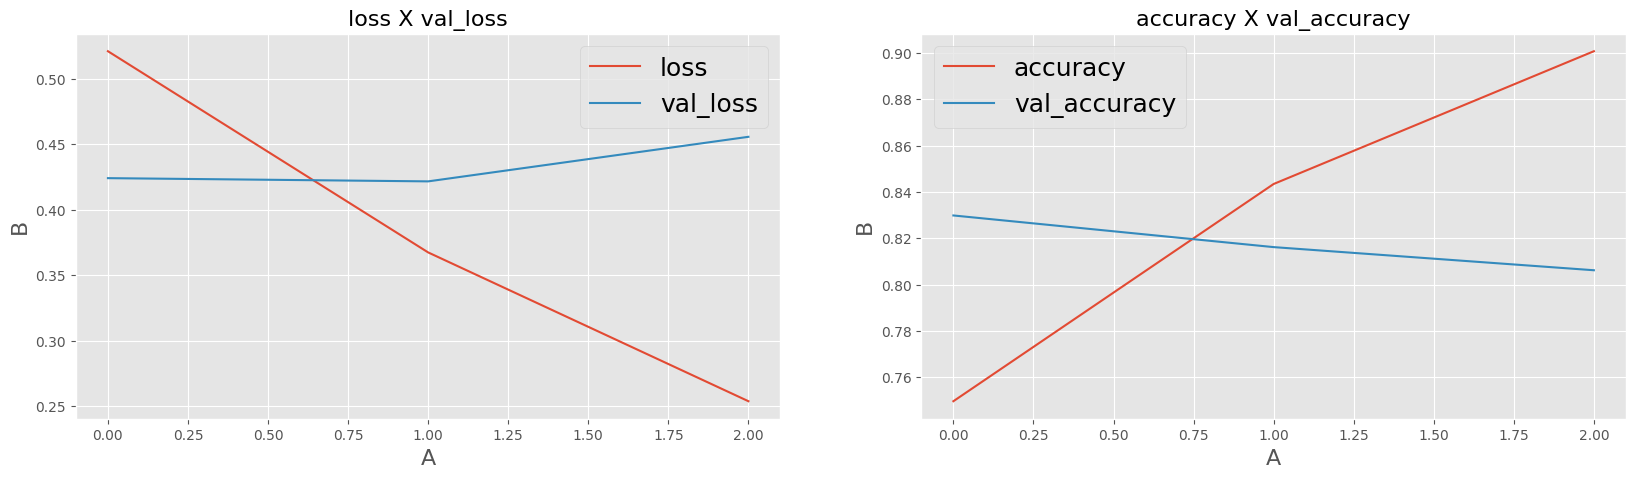

In [28]:
training(model, 'model_cnn')

####  RNN
Red neuronal recurrente (RNN) con capas bidireccionales

In [29]:
def RNN():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=length_long_sentence))
    model.add(Bidirectional(SimpleRNN(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = RNN()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 72, 100)           2270100   
                                                                 
 bidirectional (Bidirection  (None, 72, 144)           24912     
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 144)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 144)               576       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 144)               0         
                                                      

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.7944 - accuracy: 0.5847
Epoch 1: val_loss improved from inf to 0.64196, saving model to model_rnn.h5
179/179 [==============================] - 20s 87ms/step - loss: 0.7944 - accuracy: 0.5847 - val_loss: 0.6420 - val_accuracy: 0.6975 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.6436 - accuracy: 0.6588
Epoch 2: val_loss improved from 0.64196 to 0.54162, saving model to model_rnn.h5
179/179 [==============================] - 18s 99ms/step - loss: 0.6436 - accuracy: 0.6588 - val_loss: 0.5416 - val_accuracy: 0.7789 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.5624 - accuracy: 0.7231
Epoch 3: val_loss improved from 0.54162 to 0.49479, saving model to model_rnn.h5
179/179 [==============================] - 30s 170ms/step - loss: 0.5624 - accuracy: 0.7231 - val_loss: 0.4948 - val_accuracy: 0.7810 - lr: 0.0010
Epoch 4/100
179/179 [==========

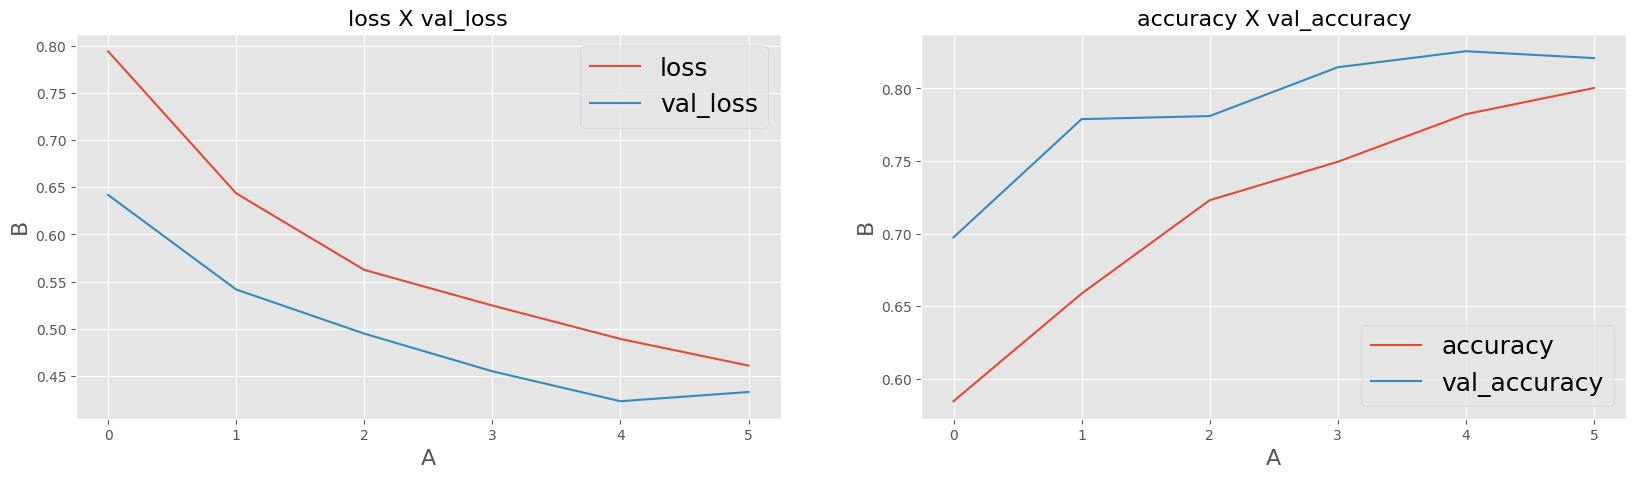

In [30]:
training(model, 'model_rnn')

#### BiGRU
Red neuronal GRU bidireccional (BiGRU).

In [31]:
def BiGRU():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=length_long_sentence))
    model.add(Bidirectional(GRU(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

model = BiGRU()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 72, 100)           2270100   
                                                                 
 bidirectional_1 (Bidirecti  (None, 72, 144)           75168     
 onal)                                                           
                                                                 
 global_max_pooling1d_1 (Gl  (None, 144)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_1 (Bat  (None, 144)               576       
 chNormalization)                                                
                                                                 
 dropout_3 (Dropout)         (None, 144)               0         
                                                      

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.7601 - accuracy: 0.6364
Epoch 1: val_loss improved from inf to 0.58048, saving model to model_bigru.h5
179/179 [==============================] - 48s 234ms/step - loss: 0.7601 - accuracy: 0.6364 - val_loss: 0.5805 - val_accuracy: 0.7337 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.5512 - accuracy: 0.7413
Epoch 2: val_loss improved from 0.58048 to 0.48422, saving model to model_bigru.h5
179/179 [==============================] - 41s 227ms/step - loss: 0.5512 - accuracy: 0.7413 - val_loss: 0.4842 - val_accuracy: 0.8004 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.4756 - accuracy: 0.7891
Epoch 3: val_loss improved from 0.48422 to 0.47886, saving model to model_bigru.h5
179/179 [==============================] - 41s 228ms/step - loss: 0.4756 - accuracy: 0.7891 - val_loss: 0.4789 - val_accuracy: 0.7957 - lr: 0.0010
Epoch 4/100
179/179 [==

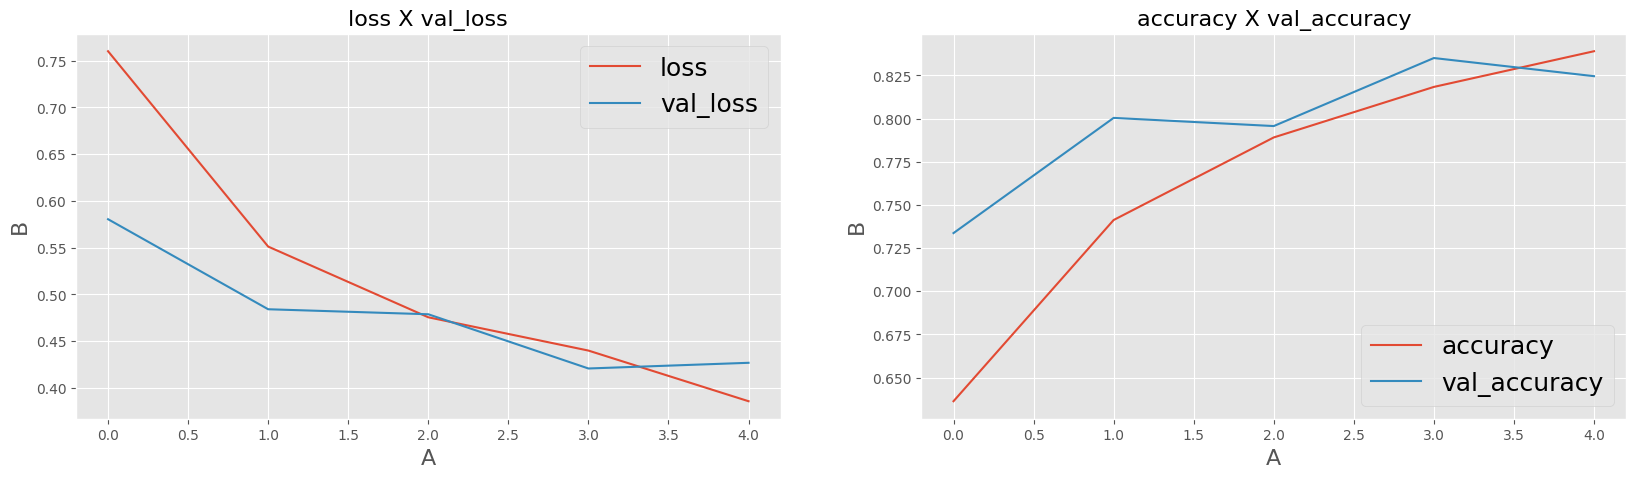

In [32]:
training(model, 'model_bigru')

#### BiLSTM
 Red neuronal LSTM bidireccional (BiLSTM).

In [33]:
def BiLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0],
                        output_dim=embedding_matrix.shape[1],
                        weights=[embedding_matrix],
                        input_length=length_long_sentence))
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences=True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Entrenamiento con técnicas de regularización
model = BiLSTM()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 72, 100)           2270100   
                                                                 
 bidirectional_2 (Bidirecti  (None, 72, 144)           99648     
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Gl  (None, 144)               0         
 obalMaxPooling1D)                                               
                                                                 
 batch_normalization_2 (Bat  (None, 144)               576       
 chNormalization)                                                
                                                                 
 dropout_6 (Dropout)         (None, 144)               0         
                                                      

Epoch 1/100
179/179 [==============================] - ETA: 0s - loss: 0.6795 - accuracy: 0.6656
Epoch 1: val_loss improved from inf to 0.59480, saving model to model_bilstm.h5
179/179 [==============================] - 50s 242ms/step - loss: 0.6795 - accuracy: 0.6656 - val_loss: 0.5948 - val_accuracy: 0.8162 - lr: 0.0010
Epoch 2/100
179/179 [==============================] - ETA: 0s - loss: 0.5217 - accuracy: 0.7635
Epoch 2: val_loss improved from 0.59480 to 0.47890, saving model to model_bilstm.h5
179/179 [==============================] - 51s 286ms/step - loss: 0.5217 - accuracy: 0.7635 - val_loss: 0.4789 - val_accuracy: 0.8157 - lr: 0.0010
Epoch 3/100
179/179 [==============================] - ETA: 0s - loss: 0.4521 - accuracy: 0.8022
Epoch 3: val_loss improved from 0.47890 to 0.43671, saving model to model_bilstm.h5
179/179 [==============================] - 47s 265ms/step - loss: 0.4521 - accuracy: 0.8022 - val_loss: 0.4367 - val_accuracy: 0.8041 - lr: 0.0010
Epoch 4/100
179/179 

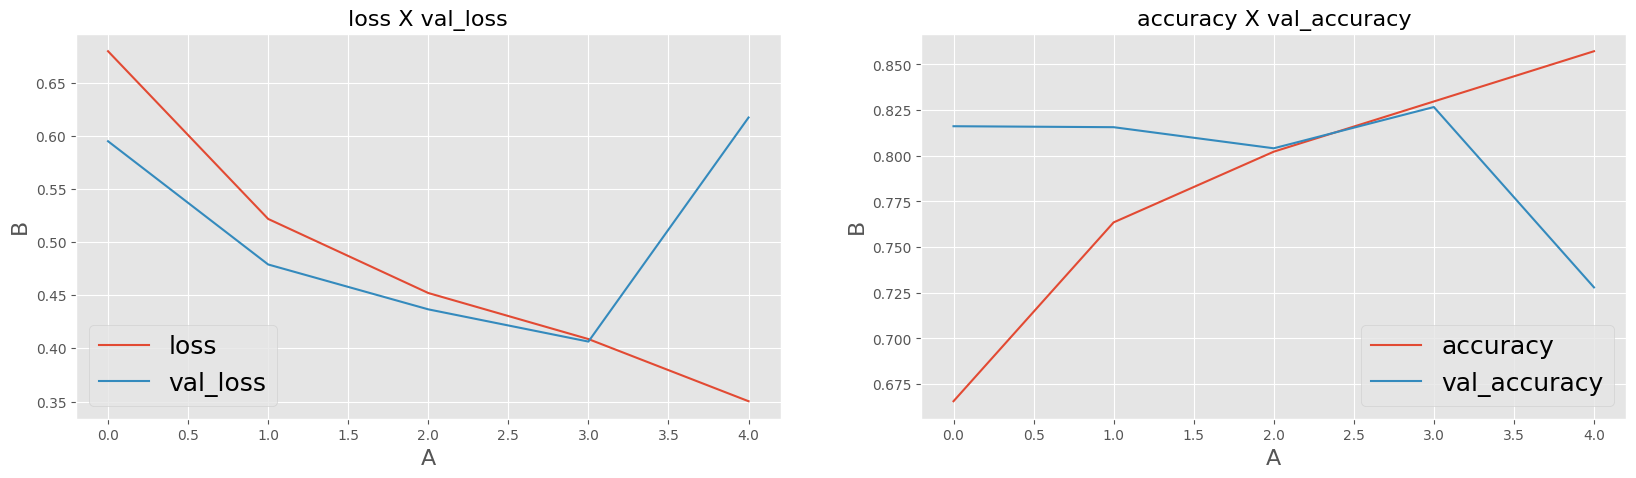

In [34]:
training(model, 'model_bilstm')

# CURVA ROC Y MATRIZ DE CONFUSION POR MODELO

60/60 [==============================] - 1s 7ms/step


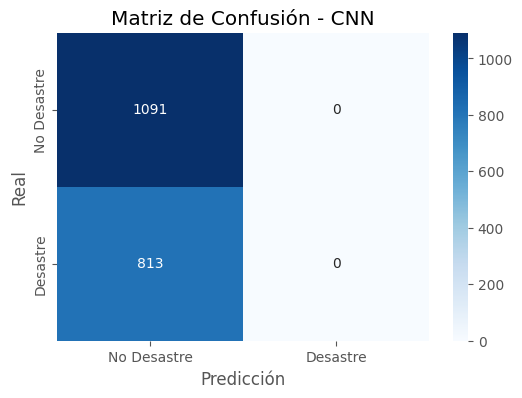

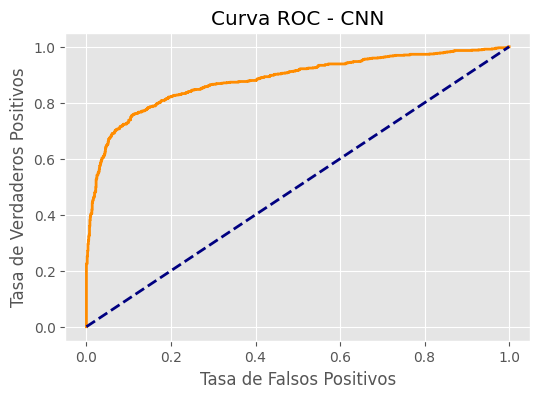

60/60 [==============================] - 1s 14ms/step


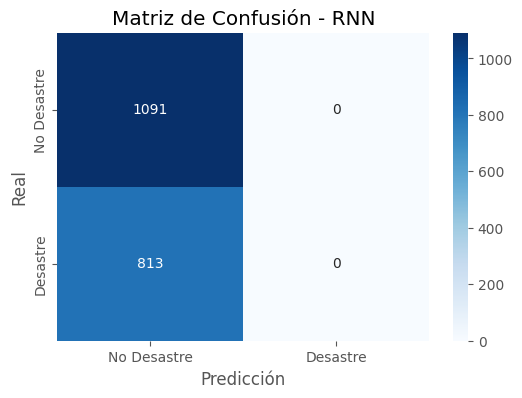

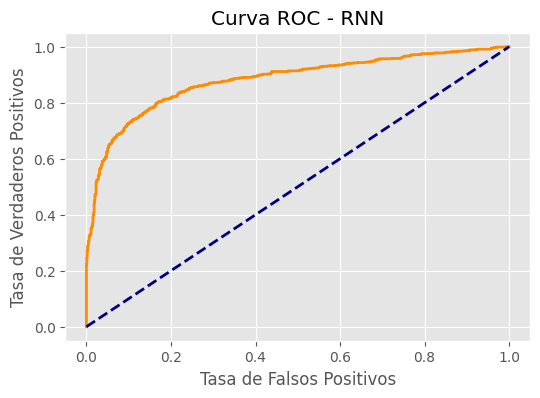

60/60 [==============================] - 2s 27ms/step


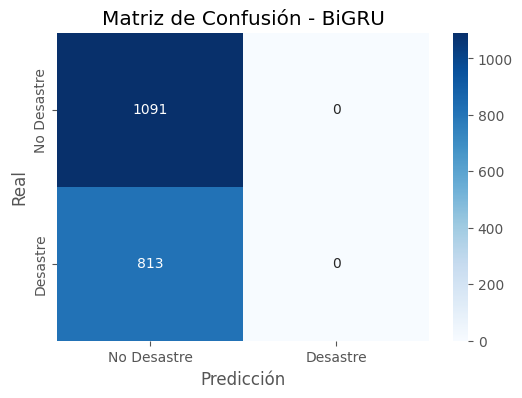

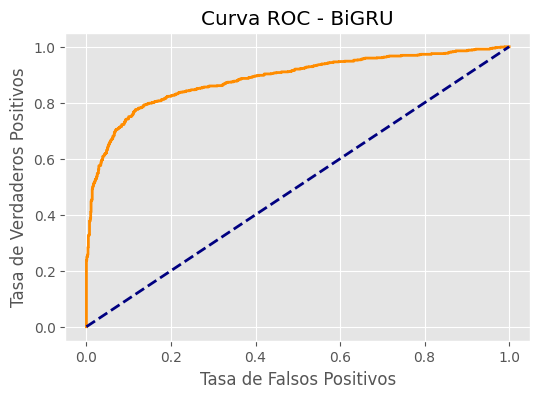

60/60 [==============================] - 2s 33ms/step


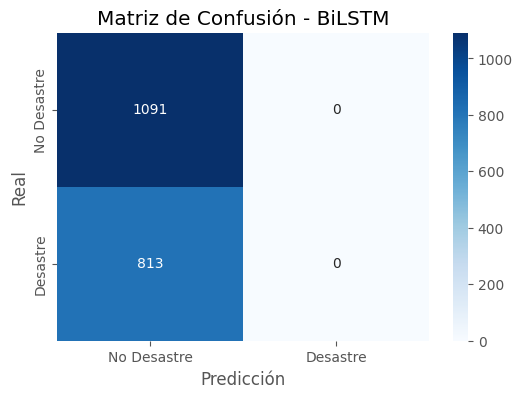

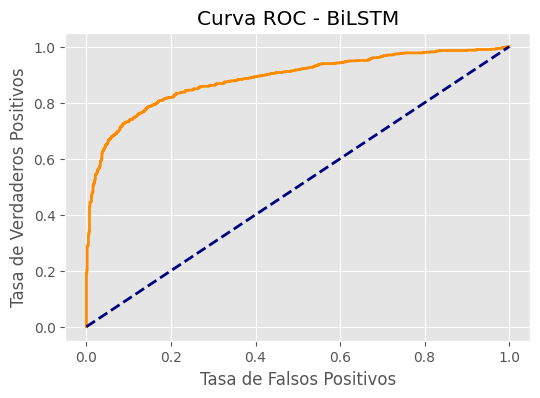

In [35]:
from keras.models import load_model
from sklearn.metrics import confusion_matrix, roc_curve, f1_score, precision_score, recall_score, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Función para mostrar la matriz de confusión
def mostrar_matriz_confusion(y_real, y_pred, nombre_modelo):
    cm = confusion_matrix(y_real, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Desastre', 'Desastre'], yticklabels=['No Desastre', 'Desastre'])
    plt.title(f'Matriz de Confusión - {nombre_modelo}')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.show()

# Función para mostrar la curva ROC
def mostrar_curva_roc(y_real, y_prob_pred, nombre_modelo):
    fpr, tpr, thresholds = roc_curve(y_real, y_prob_pred)
    plt.figure(figsize=(6, 4))
    plt.plot(fpr, tpr, color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title(f'Curva ROC - {nombre_modelo}')
    plt.show()

# Evaluar y recopilar métricas para cada modelo
modelos = ['CNN', 'RNN', 'BiGRU', 'BiLSTM']
metricas_dict = {}

for nombre_modelo in modelos:
    # Cargar el modelo (asumiendo que ya han sido entrenados)
    modelo = load_model(f'model_{nombre_modelo.lower()}.h5')

    # Predicciones
    y_prob_pred = modelo.predict(X_test)
    y_pred = np.argmax(y_prob_pred, axis=-1)

    # Mostrar la matriz de confusión
    mostrar_matriz_confusion(y_test, y_pred, nombre_modelo)

    # Mostrar la curva ROC (si se tienen probabilidades)
    mostrar_curva_roc(y_test, y_prob_pred, nombre_modelo)

    # Calcular métricas adicionales
    f1 = f1_score(y_test, y_pred, average='micro')
    precision = precision_score(y_test, y_pred, average='micro')
    recall = recall_score(y_test, y_pred, average='micro')
    reporte_clasificacion = classification_report(y_test, y_pred, target_names=['No Desastre', 'Desastre'], output_dict=True)

    # Almacenar métricas en un diccionario
    metricas_dict[nombre_modelo] = {
        'Puntaje F1': f1,
        'Precisión': precision,
        'Recuperación': recall,
        'Reporte de Clasificación': reporte_clasificacion
    }

# Ahora puedes analizar las métricas almacenadas en el diccionario metricas_dict


# Evaluación
* Evaluación de los modelos entrenados en los datos de prueba y visualización de métricas de rendimiento.
* Creación de un archivo de presentación para su posterior envío.

| Model     | F1   | Precision | Recall | Training Time | Inference Time | Model Size |
|-----------|------|-----------|--------|---------------|----------------|------------|
| 1D CNN    | 0.78 | 0.73      | 0.83   | 10.9 s        | 0.1 ms         | 26.4 MB    |
| SimpleRNN | 0.76 | 0.69      | 0.85   | 57.3 s        | 0.5 ms         | 26.5 MB    |
| BiGRU     | 0.79 | 0.79      | 0.79   | 100.6 s       | 0.7 ms         | 27.1 MB    |
| BiLSTM    | 0.79 | 0.73      | 0.85   | 89.5 s        | 0.8 ms         | 27.4 MB    |

In [36]:
submission.target = np.argmax(model.predict(test_sentences), axis=-1)

submission.to_csv("submission.csv", index=False)

102/102 [==============================] - 5s 47ms/step


In [37]:
test_preds = (model.predict(test_sentences) > 0.5).astype("int32")
print('sklearn f1_score average=micro:', f1_score(gt_df['target'], test_preds, average='micro'))
print('classification_report accuracy:', classification_report(gt_df['target'], test_preds, output_dict=True)['accuracy'])
print(classification_report(gt_df['target'], test_preds))

102/102 [==============================] - 3s 31ms/step
sklearn f1_score average=micro: 0.8081520073551947
classification_report accuracy: 0.8081520073551947
              precision    recall  f1-score   support

           0       0.77      0.95      0.85      1861
           1       0.90      0.62      0.74      1402

    accuracy                           0.81      3263
   macro avg       0.83      0.79      0.79      3263
weighted avg       0.83      0.81      0.80      3263

